 # **Spaceship Titanic**

### Predict which passengers are transported to an alternate dimension




## **1. Знакомство с данными EDA**

### Импорты

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install joblib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#распределение данных на тренировочную и тестовую, кросс-валидация
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold

#модели
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression

#игнор предупреждений
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#обработка пропущенных значений, масштабирование
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# #создание новых признаков
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import SelectKBest, f_classif

#сохранине модели
#import pickle
import joblib

#метрики
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount
cwd = os.getcwd()
print(cwd)

/content


### Загрузка данных

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/spaceship-titanic/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/spaceship-titanic/train.csv')

In [ ]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Из результатов видно, что у тестового датасета отсутствует столбец Transported, которая в тренировочном датасете имеет тип данных bool. Также видны пропуски и количества строк, столбцов, где используются для возраста и услуг float, а в остальном используется тип object для текстовых или категориальных данных

In [ ]:
train_data.shape

(8693, 14)

In [ ]:
train_data.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


Узнаем значения для числовых признаков

In [ ]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
# для типа bool у столбца Transported посмотрим на распределение целевой переменной
train_data['Transported'].value_counts()

,count
Transported,
True,4378
False,4315


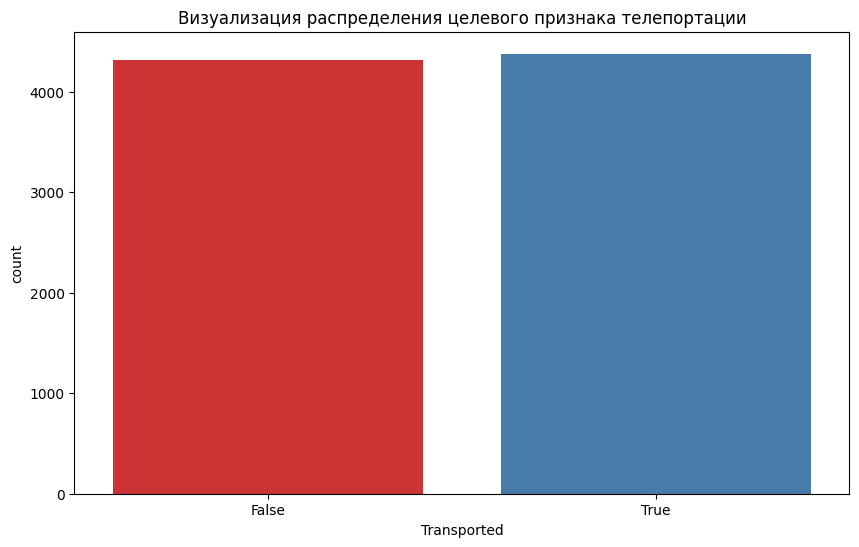

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_data, x='Transported', palette='Set1')
plt.title('Визуализация распределения целевого признака телепортации')
plt.show()

Как видно из результатов, целевая переменная Transported сбалансирована, следовательно, не нужно беспокоиться о разнице классов при дальнейшем обучении модели

In [ ]:
# изучим распределение числовых признаков
numerical_cols = train_data.select_dtypes(include=['float64']).columns
for col in numerical_cols:
  print(f'\nРаспределение {col}: \n', train_data[col].value_counts())


Распределение Age: 
 Age
24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: count, Length: 80, dtype: int64

Распределение RoomService: 
 RoomService
0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: count, Length: 1273, dtype: int64

Распределение FoodCourt: 
 FoodCourt
0.0       5456
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: count, Length: 1507, dtype: int64

Распределение ShoppingMall: 
 ShoppingMall
0.0       5587
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: count, Length: 1115, dtype: int64

Распределение Spa: 
 Spa
0.0       5324
1.0        146
2.0      

In [ ]:
# категориальные признаки
categorical_cols = train_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
  print(f'\nРаспределение {col}: \n', train_data[col].value_counts())


Распределение PassengerId: 
 PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64

Распределение HomePlanet: 
 HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

Распределение CryoSleep: 
 CryoSleep
False    5439
True     3037
Name: count, dtype: int64

Распределение Cabin: 
 Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64

Распределение Destination: 
 Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

Распределение VIP: 
 VIP
False    8291
True      199
Name: count, dtype: int64

Распределение Name: 
 Name
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala 

In [ ]:
# категориальные признаки с разбивкой по целевой переменной
for col in categorical_cols:
    print(train_data.groupby('Transported')[col].value_counts(normalize=True).unstack())

PassengerId   0001_01   0002_01   0003_01   0003_02   0004_01   0005_01  \
Transported                                                               
False        0.000232       NaN  0.000232  0.000232       NaN       NaN   
True              NaN  0.000228       NaN       NaN  0.000228  0.000228   

PassengerId   0006_01   0006_02   0007_01   0008_01  ...   9272_02   9274_01  \
Transported                                          ...                       
False             NaN       NaN       NaN       NaN  ...  0.000232       NaN   
True         0.000228  0.000228  0.000228  0.000228  ...       NaN  0.000228   

PassengerId   9275_01   9275_02   9275_03   9276_01   9278_01   9279_01  \
Transported                                                               
False             NaN  0.000232       NaN  0.000232  0.000232       NaN   
True         0.000228       NaN  0.000228       NaN       NaN  0.000228   

PassengerId   9280_01   9280_02  
Transported                      
False    

Видно, что необходимо преобразовать булевый тип в числовой и заполнить пропуски

In [ ]:
# корреляция числовых признаков с целевой переменной
numcat_col = train_data.select_dtypes(include=['int64', 'float64']).columns
target_col = 'Transported'

correlations = train_data[numerical_cols].apply(lambda x: x.corr(train_data[target_col] * 1.0))
print('\nКорреляция числовых признаков с целевой переменной:\n', correlations)


Корреляция числовых признаков с целевой переменной:
 Age            -0.075026
RoomService    -0.244611
FoodCourt       0.046566
ShoppingMall    0.010141
Spa            -0.221131
VRDeck         -0.207075
dtype: float64


### Визуализация

Исследуем числовые, категориальные признаки и установим взаимосвязь признаков с целевой переменной с помощью визуального анализа данных

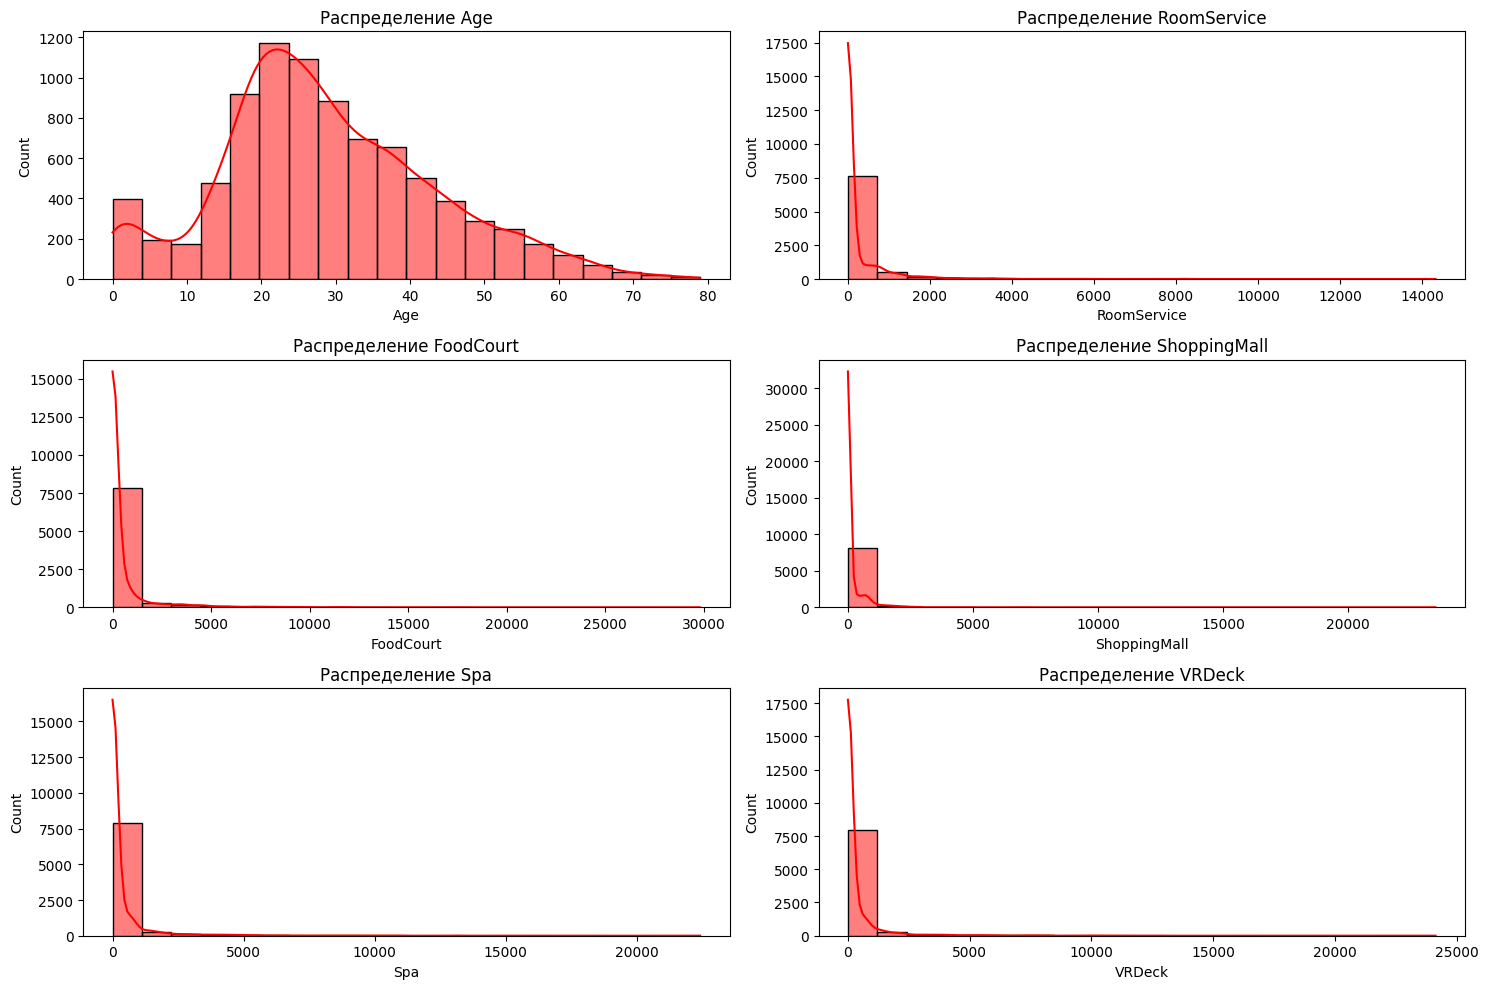

In [ ]:
#Распределение числовых признаков
plt.figure(figsize=(15,10))
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i, feature in enumerate(numeric_features):
  plt.subplot(3, 2, i+1)
  sns.histplot(train_data[feature], bins=20, kde=True, color='red')
  plt.title(f'Распределение {feature}')
  plt.xlabel(feature)
  plt.ylabel('Count')
plt.tight_layout()
plt.show()

Из графиков следует, что большинство пассажиров — молодые люди около 18–24 года, а значит, они вероятно могли предпочти криосон. Малая актуальность в услугах, что говорит о малых затратах, но встречаются моменты с высокими расходами, возможно, это либо выбросы, либо VIP-пассажиры

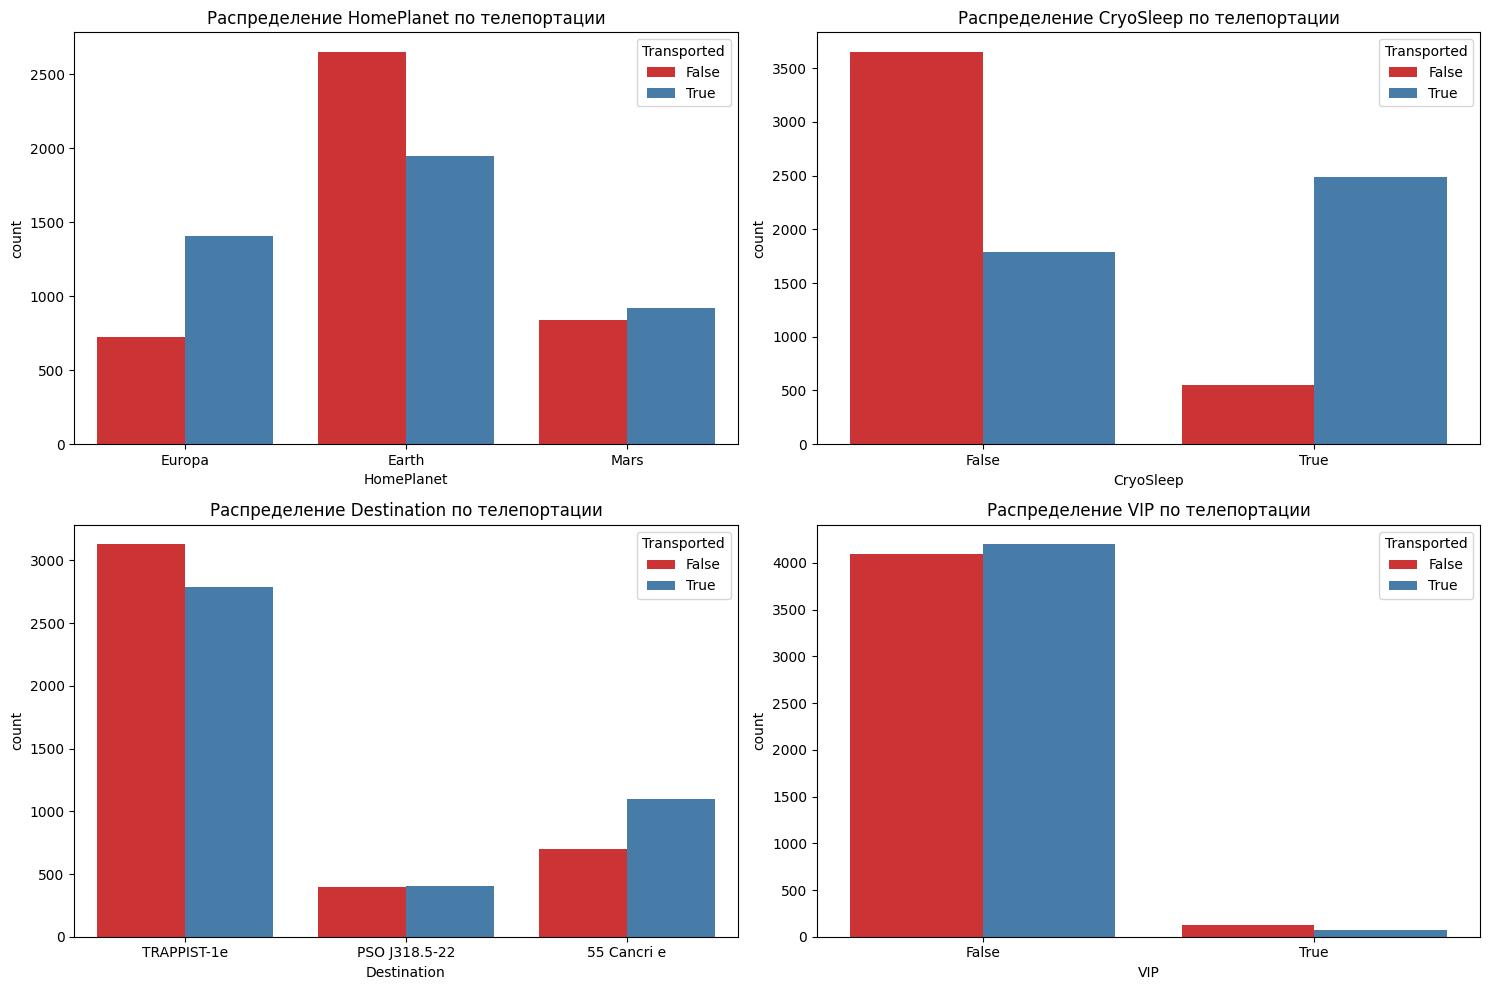

In [ ]:
#Категориальные признаки, как на них влияет телепортация
plt.figure(figsize=(15,10))
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for i, feature in enumerate(categorical_features):
  plt.subplot(2, 2, i+1)
  sns.countplot(data=train_data, x=feature, hue='Transported', palette='Set1')
  plt.title(f'Распределение {feature} по телепортации')
plt.tight_layout()
plt.show()

Далее, по графику видно, как распределение значений категориальных признаков зависит от целевой переменной телепортации: например, что пассажиры с Европы чаще телепортировались, чем те, кто отправился с Земли. Также видно, что те, кто находился в анабиозе, имели значительно более высокую вероятность телепортации


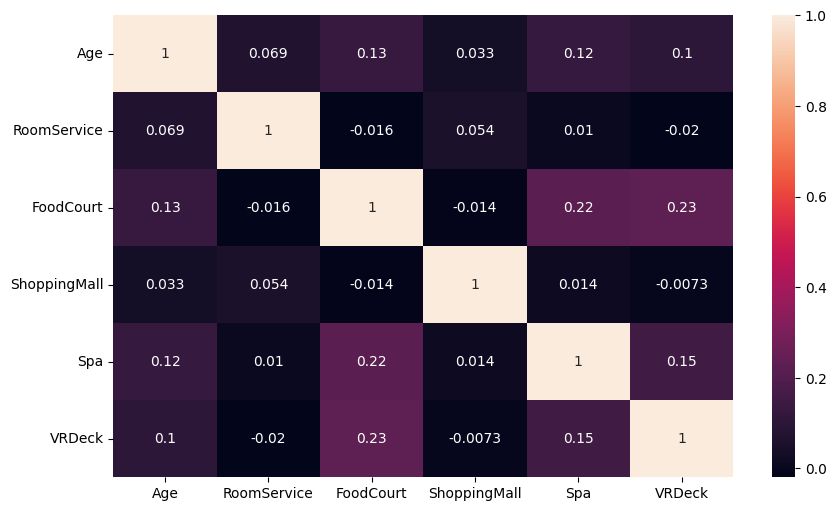

In [ ]:
# Корреляция числовых признаков с целевой переменной
plt.figure(figsize=(10, 6))
correlation_matrix = train_data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Наиболее значимые признаки: RoomService, Spa, VRDeck. Они имеют умеренную обратную корреляцию с целевой переменной. Расходы на FoodCourt и ShoppingMall почти не влияют на телепортацию

## **2. Предобработка данных**

### Обработка пропусков

Заполнение пропусков для числовых признаков

In [ ]:
for columns in numeric_features:
  median_val = train_data[columns].median()
  train_data[columns].fillna(median_val, inplace=True)
  test_data[columns].fillna(median_val, inplace=True)

Заполнение пропусков для категориальных признаков

In [ ]:
#заполним пропуски модой, наиболее часто встречающимся значением, либо можно исп unknown
for columns in categorical_features:
  mode_val = train_data[columns].mode()[0]
  train_data[columns].fillna(mode_val, inplace=True)
  test_data[columns].fillna(mode_val, inplace=True)

Обработам признак Cabin, который имеет формат палуба/номер/сторона, разделим его на три части и обработаем каждую часть отдельно

In [ ]:
# func для разделения cabin
def split_cab(cabin):
  if pd.isna(cabin):
    return np.nan, np.nan, np.nan
  parts = cabin.split('/')
  return parts[0], parts[1], parts[2] if len(parts) == 3 else (np.nan, np.nan, np.nan)

# делаем три новых признака для каюты/палубы
train_data['CabinDeck'], train_data['CabinNum'], train_data['CabinSide'] = zip(*train_data['Cabin'].apply(split_cab))
test_data['CabinDeck'], test_data['CabinNum'], test_data['CabinSide'] = zip(*test_data['Cabin'].apply(split_cab))

# удаляем исходный признак cabin
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)


In [ ]:
# обработка пропусков в новых признаках cabin
train_data['CabinDeck'].fillna(train_data['CabinDeck'].mode()[0], inplace=True)
train_data['CabinSide'].fillna(train_data['CabinSide'].mode()[0], inplace=True)
train_data['CabinNum'] = train_data['CabinNum'].astype(float)
train_data['CabinNum'].fillna(train_data['CabinNum'].median(), inplace=True)

test_data['CabinDeck'].fillna(test_data['CabinDeck'].mode()[0], inplace=True)
test_data['CabinSide'].fillna(test_data['CabinSide'].mode()[0], inplace=True)
test_data['CabinNum'] = test_data['CabinNum'].astype(float)
test_data['CabinNum'].fillna(test_data['CabinNum'].median(), inplace=True)

Также можно обработать признак Name, который включает в себе два признака в одном

In [ ]:
#извлечем фамилии
train_data['Surname'] = train_data['Name'].str.split().str[-1]
test_data['Surname'] = test_data['Name'].str.split().str[-1]

#пропуски заполним в этот раз с помощью unknown
train_data['Surname'].fillna('Unknown', inplace=True)
test_data['Surname'].fillna('Unknown', inplace=True)

#удаляем Name, хотя можно было бы присвоить ему [0], но не знаю
train_data.drop('Name', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)

In [ ]:
test_data.isnull().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0


In [ ]:
train_data.isnull().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0


Создание новых признаков

In [ ]:
#общие расходы на пассажира на титанике
train_data['TotalBill'] = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_data['TotalBill'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

#группируем фамилии, если одинаковые = семья ? один
train_data['FamGroup'] = train_data.groupby('Surname')['Surname'].transform('count')
test_data['FamGroup'] = test_data.groupby('Surname')['Surname'].transform('count')
train_data.loc[train_data['Surname'] == 'Unknown', 'FamGroup'] = 1
test_data.loc[test_data['Surname'] == 'Unknown', 'FamGroup'] = 1

#взаимоотношение возраста к расходам
train_data['AgeToBill'] = train_data['TotalBill'] / (train_data['Age'] + 1)
test_data['AgeToBill'] = test_data['TotalBill'] / (test_data['Age'] + 1)

#если сторона палубы P - 1 ? 0
train_data['PSide'] = (train_data['CabinSide'] == 'P').astype(int)
test_data['PSide'] = (test_data['CabinSide'] == 'P').astype(int)

In [ ]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,Surname,TotalBill,FamGroup,AgeToBill,PSide
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3.0,S,Carsoning,0.0,4,0.000000,0
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4.0,S,Peckers,2832.0,1,141.600000,0
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0.0,S,Unhearfus,0.0,1,0.000000,0
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1.0,S,Caltilter,7418.0,1,190.205128,0
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5.0,S,Harperez,645.0,3,30.714286,0


In [ ]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinNum,CabinSide,Surname,TotalBill,FamGroup,AgeToBill,PSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,Ofracculy,0.0,1,0.000000,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,Vines,736.0,4,29.440000,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,Susent,10383.0,6,175.983051,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,Susent,5176.0,6,152.235294,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,Santantines,1091.0,6,64.176471,0


In [ ]:
train_data[['TotalBill', 'FamGroup', 'AgeToBill', 'PSide']].describe()

,TotalBill,FamGroup,AgeToBill,PSide
count,8693.000000,8693.000000,8693.000000,8693.000000
mean,1440.866329,5.326240,46.668587,0.483838
std,2803.045694,2.934528,89.693879,0.499767
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000
50%,716.000000,5.000000,21.490909,0.000000
75%,1441.000000,7.000000,50.475000,1.000000
max,35987.000000,18.000000,1604.105263,1.000000


Выполним кодирование категориальных признаков и подготовим данные для моделирования. Этот этап важен, так как большинство алгоритмов машинного обучения работают только с числовыми данными

In [ ]:
#для номинальных признаков HomePlanet, Destination, Deck - OneHotEncoder
categorical_features = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']

encoder = OneHotEncoder(drop='first', sparse_output=False) #drop='first' от мультиколлинеарности

#кодируем кат признаки
train_enc = encoder.fit_transform(train_data[categorical_features])
test_enc = encoder.transform(test_data[categorical_features])

#преобразуем результаты в DF
train_enc_df = pd.DataFrame(train_enc, columns=encoder.get_feature_names_out(categorical_features))
test_enc_df = pd.DataFrame(test_enc, columns=encoder.get_feature_names_out(categorical_features))

#добавляем признаки в датасет
train_data = pd.concat([train_data.drop(categorical_features, axis=1), train_enc_df], axis=1)
test_data = pd.concat([test_data.drop(categorical_features, axis=1), test_enc_df], axis=1)

In [ ]:
train_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
#для бинарных призн: преобразуем в числа для моделей
binary_features = ['CryoSleep', 'VIP', 'PSide']

for col in binary_features:
  train_data[col] = train_data[col].astype(int)
  test_data[col] = test_data[col].astype(int)

In [ ]:
#удаляем ненужные признаки
drop_col = ['PassengerId', 'Surname', 'Transported']

#разделенне данных на признаки X и целевую переменную y
X = train_data.drop(drop_col, axis=1)
y = train_data['Transported']

print(X.shape)
print(y.shape)

(8693, 25)
(8693,)


 Масштабирование числовых признаков

In [ ]:
#стандартизация числовых признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler=StandardScaler()

#масштабирование
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [ ]:
numeric_features = test_data.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
test_data[numeric_features] = scaler.fit_transform(test_data[numeric_features])

In [ ]:
drop_columns = ['PassengerId', 'Surname']
X_test = test_data.drop(drop_columns, axis=1)

In [ ]:
X.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,TotalBill,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S
0,-0.73277,0.711945,-0.153063,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.177238,-0.514066,...,-0.317487,0.652521,3.187347,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,-1.032865
1,-0.73277,-0.334037,-0.153063,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.177238,-0.251479,...,-0.317487,0.652521,-0.313741,-0.30661,-0.241218,-0.334759,1.380016,-0.645897,-0.02399,0.968181
2,-0.73277,2.036857,6.533255,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.177238,3.190333,...,-0.317487,0.652521,-0.313741,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,0.968181
3,-0.73277,0.293552,-0.153063,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.177238,1.332604,...,-0.317487,0.652521,-0.313741,-0.30661,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,0.968181
4,-0.73277,-0.891895,-0.153063,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.175264,-0.124824,...,-0.317487,0.652521,-0.313741,-0.30661,-0.241218,-0.334759,1.380016,-0.645897,-0.02399,0.968181


Разделение данных на обучающую и валидационную выборки для модели

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

X_train: (6954, 25)
X_val: (1739, 25)
y_train: (6954,)
y_val: (1739,)


## **3. Моделирование**

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# XGBoost
# гиперпараметры
pxgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=pxgb,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)
best_xgb_model = random_search_xgb.best_estimator_

#cross-validation
xgb_cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost: среднее Accuracy = {xgb_cv_scores.mean():.4f}, стандартное отклонение = {xgb_cv_scores.std():.4f}")

#validation
y_predxgb = best_xgb_model.predict(X_val)
y_predxgb_proba = best_xgb_model.predict_proba(X_val)[:, 1]
accuracy_xgb = accuracy_score(y_val, y_predxgb)
roc_auc_xgb = roc_auc_score(y_val, y_predxgb_proba)
print(f"XGBoost Accuracy на валидации: {accuracy_xgb:.4f}")
print(f"XGBoost ROC-AUC на валидации: {roc_auc_xgb:.4f}")
print("\nClassification Report для XGBoost:")
print(classification_report(y_val, y_predxgb))
print("Confusion Matrix для XGBoost:")
print(confusion_matrix(y_val, y_predxgb))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost: среднее Accuracy = 0.8100, стандартное отклонение = 0.0045
XGBoost Accuracy на валидации: 0.8033
XGBoost ROC-AUC на валидации: 0.9007

Classification Report для XGBoost:
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       861
        True       0.80      0.81      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Confusion Matrix для XGBoost:
[[682 179]
 [163 715]]


In [ ]:
# CatBoost
# гиперпараметры
pcat = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4,6,8],
    'l2_leaf_reg': [1, 3, 5]
}

random_search_cat = RandomizedSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_distributions=pcat,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42
)

random_search_cat.fit(X_train, y_train)
best_cat_model = random_search_cat.best_estimator_

# cross-val
cat_cv_scores = cross_val_score(best_cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CatBoost: среднее Accuracy = {cat_cv_scores.mean():.4f}, стандартное отклонение = {cat_cv_scores.std():.4f}")

# val
y_predcat = best_cat_model.predict(X_val)
y_predcat_proba = best_cat_model.predict_proba(X_val)[:, 1]

accuracy_cat = accuracy_score(y_val, y_predcat)
roc_auc_cat = roc_auc_score(y_val, y_predcat_proba)
print(f"CatBoost Accuracy на валидации: {accuracy_cat:.4f}")
print(f"CatBoost ROC-AUC на валидации: {roc_auc_cat:.4f}")
print("\nClassification Report для CatBoost:")
print(classification_report(y_val, y_predcat))
print("Confusion Matrix для CatBoost:")
print(confusion_matrix(y_val, y_predcat))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CatBoost: среднее Accuracy = 0.8136, стандартное отклонение = 0.0039
CatBoost Accuracy на валидации: 0.8068
CatBoost ROC-AUC на валидации: 0.9050

Classification Report для CatBoost:
              precision    recall  f1-score   support

       False       0.81      0.80      0.80       861
        True       0.80      0.82      0.81       878

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739

Confusion Matrix для CatBoost:
[[686 175]
 [161 717]]


In [ ]:
# LightGMB
plgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [3, 6, 9]
}

random_search_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=plgb,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42
)

random_search_lgb.fit(X_train, y_train)
best_lgb_model = random_search_lgb.best_estimator_

# cross-val
lgb_cv_scores = cross_val_score(best_lgb_model, X_train, y_train, cv=5,scoring='accuracy')
print(f"LightGBM: среднее Accuracy = {lgb_cv_scores.mean():.4f}, стандартное отклонение = {lgb_cv_scores.std():.4f}")

# val
y_predlgb = best_lgb_model.predict(X_val)
y_predlgb_proba = best_lgb_model.predict_proba(X_val)[:, 1]

import warnings
warnings.filterwarnings("ignore")

accuracy_lgb = accuracy_score(y_val, y_predlgb)
roc_auc_lgb = roc_auc_score(y_val, y_predlgb_proba)
print(f"LightGBM Accuracy на валидации: {accuracy_lgb:.4f}")
print(f"LightGBM ROC-AUC на валидации: {roc_auc_lgb:.4f}")
print("\nClassification Report для LightGBM:")
print(classification_report(y_val, y_predlgb))
print("Confusion Matrix для LightGBM:")
print(confusion_matrix(y_val, y_predlgb))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

 Ансамбль CatBoost + XGBoost

In [ ]:
# func кросс-валидации ансамбля
def ensemle_cross_val(X,y,model1,model2,cv=5):
  kf = KFold(n_splits=cv,shuffle=True,random_state=42)
  scores=[]
  for train_i, val_i in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_i], X.iloc[val_i]
    y_train_fold, y_val_fold = y.iloc[train_i], y.iloc[val_i]

    model1.fit(X_train_fold, y_train_fold) # обучаем модели на фолде
    model2.fit(X_train_fold, y_train_fold)

    #предсказание вероятностей
    y_pred1 = model1.predict_proba(X_val_fold)[:, 1]
    y_pred2 = model2.predict_proba(X_val_fold)[:, 1]

    #среднее предсказание вероятностей
    y_pred_mean = (y_pred1 + y_pred2) / 2
    y_pred_mean_class = (y_pred_mean >= 0.5).astype(int) #преобразование вероятностей в бинарные классы

    #оцениваем качество
    fold_accuracy = accuracy_score(y_val_fold, y_pred_mean_class)
    scores.append(fold_accuracy)

  return np.mean(scores), np.std(scores)

# cross-val ensemble
ensemble_mean, ensemble_std = ensemle_cross_val(X_train, y_train, best_cat_model, best_xgb_model, cv=5)
print(f"Ансамбль (CatBoost && XGBoost): среднее Accuracy = {ensemble_mean:.4f}, стандартное отклонение = {ensemble_std:.4f}")

# предсказания ансамбля на валидации
y_predcat_proba = best_cat_model.predict_proba(X_val)[:, 1]
y_predxgb_proba = best_xgb_model.predict_proba(X_val)[:, 1]

y_predmean = (y_predcat_proba + y_predxgb_proba) / 2 # среднее
y_predbin = (y_predmean >= 0.5).astype(int) # binary classification

accuracy_ensemble = accuracy_score(y_val, y_predbin)
roc_auc_ensemble = roc_auc_score(y_val, y_predmean)
print(f"Accuracy ансамбля на валидации: {accuracy_ensemble:.4f}")
print(f"ROC-AUC ансамбля на валидации: {roc_auc_ensemble:.4f}")
print("\nClassification Report для ансамбля:")
print(classification_report(y_val, y_predbin))
print("Confusion Matrix для ансамбля:")
print(confusion_matrix(y_val, y_predbin))

Ансамбль (CatBoost && XGBoost): среднее Accuracy = 0.8073, стандартное отклонение = 0.0081
Accuracy ансамбля на валидации: 0.7982
ROC-AUC ансамбля на валидации: 0.8984

Classification Report для ансамбля:
              precision    recall  f1-score   support

       False       0.80      0.79      0.80       861
        True       0.80      0.80      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Confusion Matrix для ансамбля:
[[684 177]
 [174 704]]


Этой функцией выполняется простое ансамблирование, где предсказания двух моделей усредняются для получения средней точности и её стандартного отклонения

По итогу CatBoost демонстрирует наилучшие результаты среди всех рассмотренных моделей с accuracy = 0.8068, отличную способность различать классы ROC-AUC = 0.9050 и стабильность на кросс-валидации низкое стандартное отклонение = 0.0039. XGBoost также показывает хорошие результаты, но уступает CatBoost по большинству метрик, включая ROC-AUC и F1-score. LightGBM, хотя и работает быстрее, оказывается менее точным и стабильным, чем CatBoost и XGBoost. Ансамбль из CatBoost и XGBoost, несмотря на ожидания, не превзошел отдельные модели: его accuracy = 0.7982 и ROC-AUC = 0.8984 оказались ниже, чем у CatBoost

Общая визуализация моделей

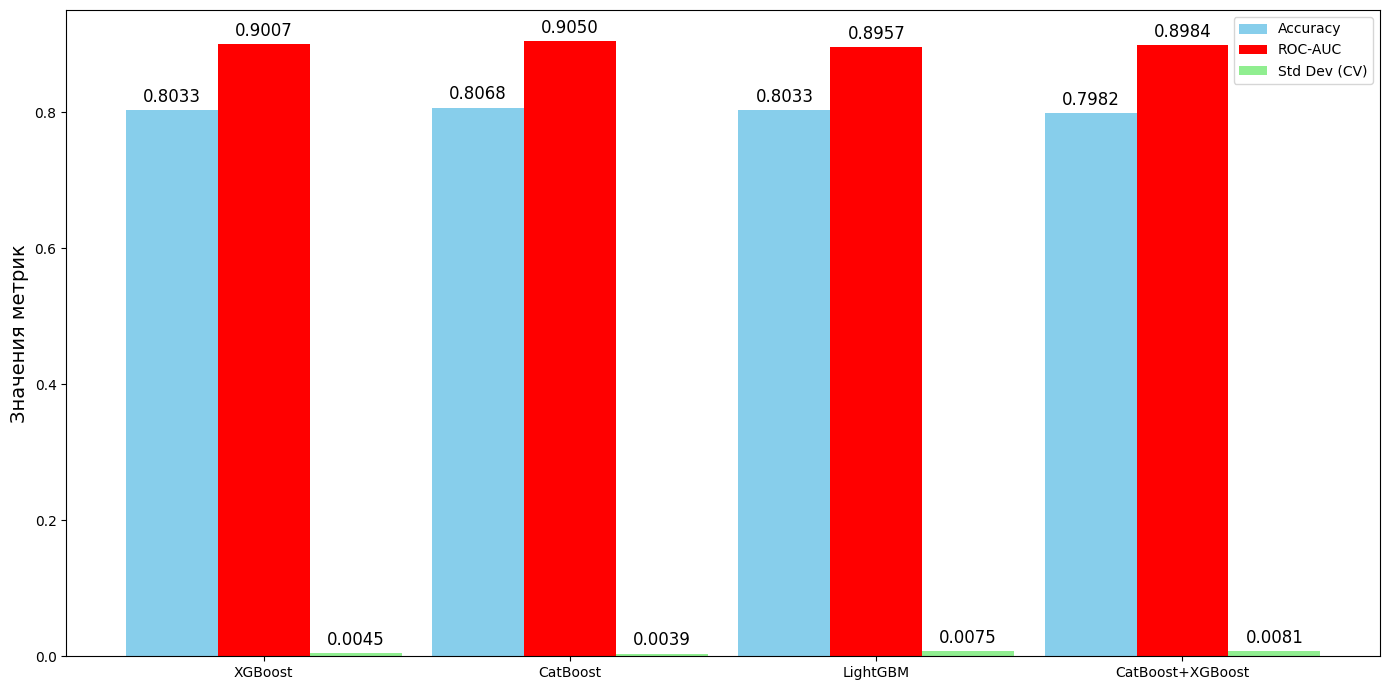

In [ ]:
models = ['XGBoost', 'CatBoost', 'LightGBM', 'CatBoost+XGBoost']
accuracy = [0.8033, 0.8068, 0.8033, 0.7982]
roc_auc = [0.9007, 0.9050, 0.8957, 0.8984]
std_dev = [0.0045, 0.0039, 0.0075, 0.0081]

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(14, 7))

bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x, roc_auc, width, label='ROC-AUC', color='red')
bars3 = ax.bar(x + width, std_dev, width, label='Std Dev (CV)', color='lightgreen')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Значения метрик', fontsize=14)
ax.legend()

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=12)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

## **4. Выгрузка на Kaggle**

In [ ]:
y_test_pred_proba = best_cat_model.predict_proba(X_test)[:, 1]
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(bool)

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Transported': y_test_pred_class
})

submission.to_csv('submission.csv', index=False)
print("Файл создан")

Файл создан


In [ ]:
joblib.dump(best_cat_model, 'catboost_model.joblib')
# best_cat_model = joblib.load('catboost_model.joblib') - хагрузка модели

['catboost_model.joblib']